In [1]:
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pyregion
import pyarrow.parquet as pq


In [2]:
extphot = pq.read_table("/home/bekah/gPhoton2/test_data/e23456/e23456-nd-b00.parquet").to_pandas()

In [12]:
filtered_df = extphot[(extphot['x'] >= 0) & (extphot['x'] <= 10000) & (extphot['y'] >= -20000) & (extphot['y'] <= -10000)]

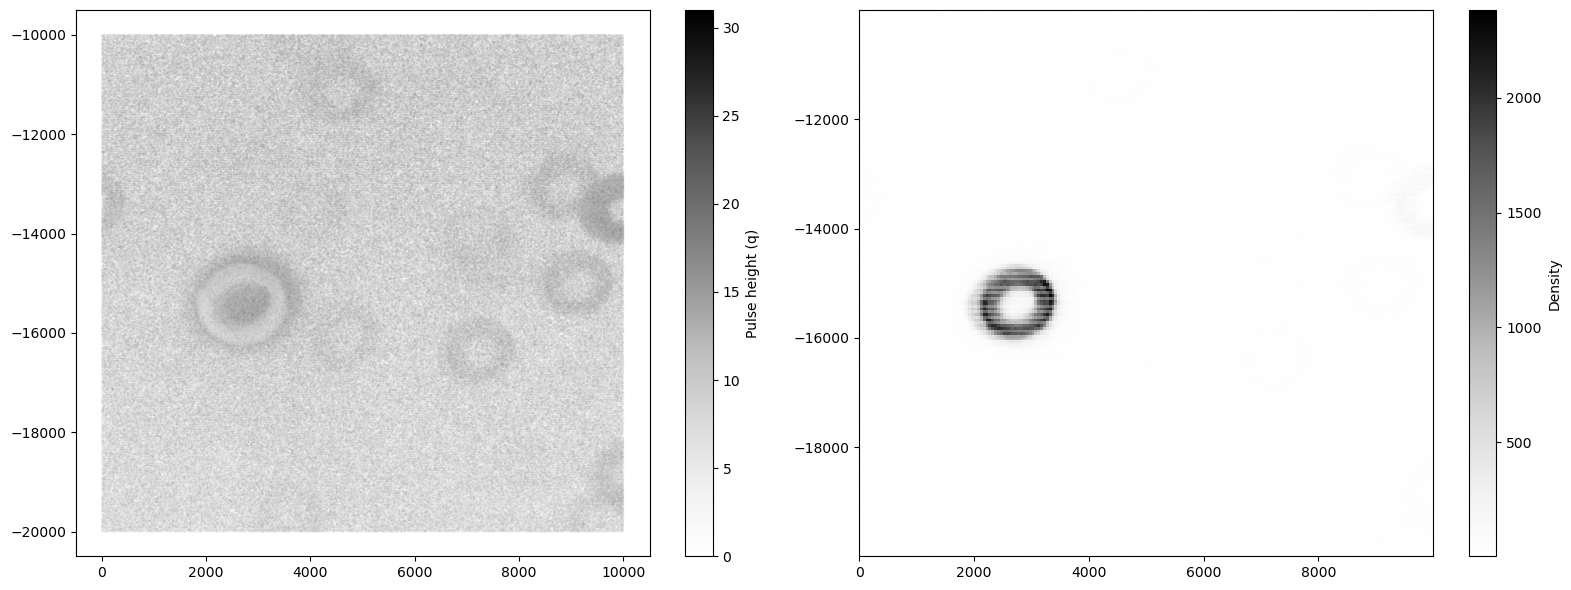

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].scatter(filtered_df['x'],filtered_df['y'],c=filtered_df['q'],s=.001,cmap='Greys')
cbar = plt.colorbar(axs[0].collections[0], ax=axs[0])
cbar.set_label('Pulse height (q)')

axs[1].hist2d(filtered_df['x'],filtered_df['y'], bins=200, cmap='Greys')
cbar2 = plt.colorbar(axs[1].collections[0],ax=axs[1])
cbar2.set_label('Density')

plt.tight_layout()

plt.show()

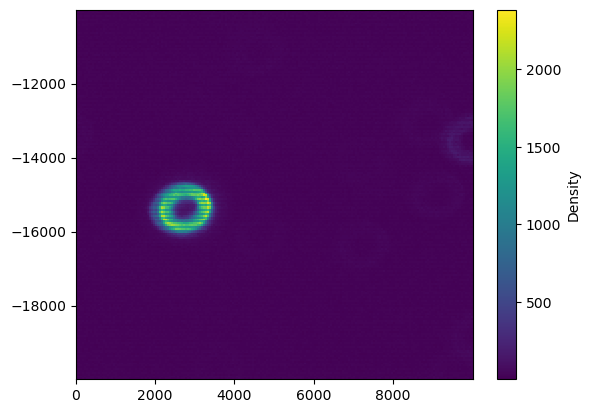

In [14]:
plt.hist2d(filtered_df['x'],filtered_df['y'], bins=200, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('Density')

In [3]:
extphot

,t,xb,xamc,yb,yamc,q,xa,ya,x,y,...,col,row,flags,ra,dec,detrad,mask,flat,scale,response
0,8.743612e+08,3,502,4,-1700,16,5,3,-7727.465820,2773.979980,...,311.925659,433.224731,0,0.0,0.0,94.132736,False,0.861674,0.985126,0.848857
1,8.743612e+08,2,1258,3,1585,7,13,31,-18686.484375,20888.910156,...,188.682922,649.018433,0,0.0,0.0,326.596222,False,0.961610,0.985126,0.947307
2,8.743612e+08,3,333,3,719,14,13,16,-9175.704102,8756.250000,...,295.313263,502.841187,0,0.0,0.0,146.750198,False,0.884901,0.985126,0.871738
3,8.743612e+08,2,120,4,-930,8,12,3,-28694.166016,13561.680664,...,80.359215,560.624634,0,0.0,0.0,357.729645,False,0.983732,0.985126,0.969100
4,8.743612e+08,4,347,3,-1422,9,7,8,8560.936523,-21239.160156,...,497.861023,149.464279,0,0.0,0.0,268.970123,False,0.854151,0.985126,0.841446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35820487,8.743629e+08,3,-631,3,606,12,5,14,-17686.535156,7173.120117,...,200.471985,483.566101,0,0.0,0.0,216.320877,False,0.941542,0.985125,0.927537
35820488,8.743629e+08,4,192,2,133,6,20,19,7259.046387,-27361.531250,...,483.260712,76.534050,0,0.0,0.0,334.009827,False,0.815818,0.985125,0.803682
35820489,8.743629e+08,3,-186,2,791,7,2,25,-13788.960938,-18142.951172,...,244.407043,184.443130,0,0.0,0.0,265.845703,False,0.832155,0.985125,0.819777
35820490,8.743629e+08,5,777,2,1857,11,8,0,29986.818359,-3208.290039,...,741.976746,362.070526,0,0.0,0.0,344.073730,False,0.916364,0.985125,0.902733


# flags 
http://www.galex.caltech.edu/wiki/Public:Documentation/Appendix_A
See above for detailed description.
        Unsigned 2-byte integer.
        Least significant bit = 0:
        0  - N/A (don't assume it's zero!)
        1  - N/A (don't assume it's zero!)
        2  - Skip
        3  - 0
        4  - 0
        5  - Stim
        6  - Masked
        7  - BadAsp
        8  - Range
        9  - Badwalk
        10 - N/A (don't assume it's zero!)
        11 - N/A (don't assume it's zero!)
        12 - N/A (don't assume it's zero!)
        13 - N/A (don't assume it's zero!)
        14 - N/A (don't assume it's zero!)
        15 - N/A (don't assume it's zero!)

In [ ]:
def avg_stimpos(band, eclipse):
    """
    Define the mean detector stim positions.

    :param band: The band to return the average stim positions for,
        either 'FUV' or 'NUV'.

    :type band: str

    :param eclipse: The eclipse number to return the average stim positions for.

    :type eclipse: int

    :returns: dict -- A dict containing the average x and y positions of the
        four stims (for the requested band).
    """

    if band == "FUV":
        avgstim = {
            "x1": -2541.88,
            "x2": 2632.06,
            "x3": -2541.53,
            "x4": 2631.68,
            "y1": 2455.28,
            "y2": 2455.02,
            "y3": -2550.89,
            "y4": -2550.92,
        }

    elif band == "NUV":
        if eclipse >= 38268:
            # The average stim positions after the clock change (post-CSP).
            avgstim = {
                "x1": -2722.53,
                "x2": 2470.29,
                "x3": -2721.98,
                "x4": 2471.09,
                "y1": 2549.96,
                "y2": 2550.10,
                "y3": -2538.57,
                "y4": -2538.62,
            }
        else:
            # The average stim positions for pre-CSP data (eclipse 37423).
            avgstim = {
                "x1": -2722.27,
                "x2": 2468.84,
                "x3": -2721.87,
                "x4": 2469.85,
                "y1": 2453.89,
                "y2": 2453.78,
                "y3": -2565.81,
                "y4": -2567.83,
            }

    else:
        raise ValueError("No valid band specified.")

    return avgstim


# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
def find_stims_index(x, y, band, eclipse, margin=90.001):
    """
    Given a list of detector x,y positions of events, returns four
        arrays that contain the indices of likely stim events for that stim,
        i.e., the first array contains positions for stim1, the second array has
        positions of stim2, etc.

        Example of how the return indexes are used: x[index1], y[index1] would
        give all of the event positions for stim1.

    :param x: Detector 'x' positions to identify likely stim events from.

    :type x: list

    :param y: Detector 'y' positions to identify likely stim events from.

    :type y: list

    :param band: The band to return the constants for, either 'FUV' or 'NUV'.

    :type band: str

    :param eclipse: The eclipse number to return the average stim positions for.

    :type eclipse: int

    :param margin: +/- extent in arcseconds defining search box

    :type margin: float

    :returns: tuple -- A four-element tuple containing arrays of indexes that
        correpond to the event positions for stim1, stim2, stim3, and stim4.
    """

    # [Future] This method could be programmed better. Consider using numpy
    # "where" and the logical '&' operator, instead of .nonzero()?

    # Plate scale (in arcsec/mm).
    pltscl = 68.754932
    # Plate scale in arcsec per micron.
    ASPUM = pltscl / 1000.0
    # [Future] Could define the plate scale (in both units) as a constant for
    # the module, since it is used in many places?

    x_as = np.array(x) * ASPUM
    y_as = np.array(y) * ASPUM

    avg = avg_stimpos(band, eclipse)

    index1 = (
        (x_as > (avg["x1"] - margin))
        & (x_as < (avg["x1"] + margin))
        & (y_as > (avg["y1"] - margin))
        & (y_as < (avg["y1"] + margin))
    ).nonzero()[0]
    index2 = (
        (x_as > (avg["x2"] - margin))
        & (x_as < (avg["x2"] + margin))
        & (y_as > (avg["y2"] - margin))
        & (y_as < (avg["y2"] + margin))
    ).nonzero()[0]
    index3 = (
        (x_as > (avg["x3"] - margin))
        & (x_as < (avg["x3"] + margin))
        & (y_as > (avg["y3"] - margin))
        & (y_as < (avg["y3"] + margin))
    ).nonzero()[0]
    index4 = (
        (x_as > (avg["x4"] - margin))
        & (x_as < (avg["x4"] + margin))
        & (y_as > (avg["y4"] - margin))
        & (y_as < (avg["y4"] + margin))
    ).nonzero()[0]

    return index1, index2, index3, index4
    #return (avg["x1"] - margin, avg["x1"] + margin, avg["y1"] - margin, avg["y1"] + margin)


In [ ]:
(68.754932/1000)*200

In [ ]:
# stim events should be in extended photonlist files (those used for dose maps)
# http://www.galex.caltech.edu/wiki/Public:Documentation/Appendix_A

eclipse = 30025
#photonlist = pq.read_table(f"/media/bekah/BekahA/backplane_widths/e{eclipse}/e{eclipse}-nd-b00.parquet").to_pandas()
photonlist = pq.read_table(f"/home/bekah/gPhoton2/test_data/e{eclipse}/e{eclipse}-nd-b00.parquet").to_pandas()

In [ ]:
y = photonlist['y']
x = photonlist['x']
t = photonlist['t']
flag = photonlist['flags']

band = "NUV"

i1, i2, i3, i4 = find_stims_index(x, y, band, eclipse, margin=90.001)

In [ ]:
#stims = pd.DataFrame()

d1 = pd.DataFrame()
d2 = pd.DataFrame()
d3 = pd.DataFrame()
d4 = pd.DataFrame()

d1['x'] = x[i1] 
d1['y'] = y[i1] 
d1['t'] = t[i1]
d1['stim'] = 1
d1['flag'] = flag[i1]

d2['x'] = x[i2] 
d2['y'] = y[i2] 
d2['t'] = t[i2]
d2['stim'] = 2
d2['flag'] = flag[i2]


d3['x'] = x[i3] 
d3['y'] = y[i3] 
d3['t'] = t[i3]
d3['stim'] = 3
d3['flag'] = flag[i3]


d4['x'] = x[i4]
d4['y'] = y[i4] 
d4['t'] = t[i4]
d4['stim'] = 4
d4['flag'] = flag[i4]


frames = [d1, d2, d3, d4]

stims = pd.concat(frames)

stims['t_div'] = stims['t'] // 2

stim_groups = stims.groupby(['stim'])

In [ ]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 2, figsize=(8, 12))

# Plot data on each subplot
for i in range(4):  # Iterate over rows
    g3 = stim_groups.get_group(i+1)
    sub = g3.groupby('t_div').mean()
    for j in range(2):  # Iterate over columns
        if j == 0:
            axs[i, j].scatter(sub.index,sub['y'],s=.5,c=sub['flag'])
            axs[i, j].set_title(f'Stim {i} Y')
                    # Determine the first time stamp in the dataset
            first_timestamp = sub.index[0]

        else:
            axs[i, j].scatter(sub.index,sub['x'],s=.5,c=sub['flag'])
            axs[i, j].set_title(f' Stim{i} X')
            first_timestamp = sub.index[0]


# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
stim2 = stim_groups.get_group(2)
stim4 = stim_groups.get_group(4)

In [ ]:
plt.scatter(stim4['t'][4000:6500],stim4['x'][4000:6500], s=.25)
plt.gca().set_aspect(.08)

In [ ]:
plt.scatter(stim4['t'][27000:29000],stim4['x'][27000:29000], s=.25)
plt.gca().set_aspect(.1)

In [ ]:
len(stim4)

In [ ]:

# Assuming 'timestamp' is the name of the column containing the time component
readings_per_second = stim2.groupby(stim2['t'] // 2).size()

print(readings_per_second)

In [ ]:
fig, axs = plt.subplots(2, figsize=(8,12))
axs[0].scatter(readings_per_second.index*2,readings_per_second,s=.1)
axs[0].set_title('readings')
axs[1].scatter(stim2['t'],stim2['y'],s=.1)
axs[1].set_title('events')
axs[1].set_ylim([35500,35850])
axs[0].set_aspect(25)
axs[1].set_aspect(.5)

In [ ]:
plt.scatter(stim2['t'],stim2['y'],s=.005)

plt.scatter(readings_per_second.index,readings_per_second, s=.25)
plt.gca().set_aspect(.01)
plt.xlabel('time')
plt.ylabel('y value of all readings')

In [ ]:
fig, axs = plt.subplots(4, figsize=(8,8))
axs[0].scatter(stim2[0:3000]['t'],stim2[0:3000]['y'],s=.1)
axs[0].set_title('Stim 2 Event 1')
axs[1].scatter(stim2[20500:23500]['t'],stim2[20500:23500]['y'],s=.1)
axs[1].set_title('Stim 2 Event 2')
axs[0].set_aspect(.08)
axs[1].set_aspect(.08)
axs[2].scatter(stim4[0:3000]['t'],stim4[0:3000]['y'],s=.1)
axs[2].set_title('Stim 4 Event 1')
axs[3].scatter(stim4[20500:23500]['t'],stim4[20500:23500]['y'],s=.1)
axs[3].set_title('Stim 4 Event 2')
axs[2].set_aspect(.08)
axs[3].set_aspect(.08)

In [ ]:
fig, axs = plt.subplots(4, figsize=(8,10))
axs[0].scatter(stim2[0:3000]['t'],stim2[0:3000]['x'],s=.1)
axs[0].set_title('Stim 2 Event 1 X Pos')
axs[1].scatter(stim2[20500:23500]['t'],stim2[20500:23500]['x'],s=.1)
axs[1].set_title('Stim 2 Event 2 X Pos')
axs[0].set_aspect(.08)
axs[1].set_aspect(.08)
axs[2].scatter(stim4[0:3000]['t'],stim4[0:3000]['x'],s=.1)
axs[2].set_title('Stim 4 Event 1 X Pos')
axs[2].set_ylim(35750,36000)
axs[3].scatter(stim4[20500:23500]['t'],stim4[20500:23500]['x'],s=.1)
axs[3].set_title('Stim 4 Event 2 X Pos')
axs[3].set_ylim(35750,36000)
axs[2].set_aspect(.08)
axs[3].set_aspect(.08)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Generate example data with a changing wavelength sine wave
x = stim2[0:3000]['t']
y = stim2[0:3000]['y']  # Example data with changing wavelength sine wave

# Define the model function
def model(x, amplitude, frequency, phase):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase)

# Define the objective function (mean squared error)
def objective_function(params):
    amplitude, frequency, phase = params
    y_pred = model(x, amplitude, frequency, phase)
    return np.mean((y_pred - y) ** 2)

# Initial guess for parameters
initial_guess = [150, 1.0, 0.0]  # [amplitude, frequency, phase]

# Fit the model to the data
best_params, _ = curve_fit(model, x, y, p0=initial_guess)

# Plot the data and the fitted curve
plt.plot(x, y, label='Data')
plt.plot(x, model(x, *best_params), label='Fitted Curve', linestyle='--')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting a Changing Wavelength Sine Wave')
plt.legend()
plt.show()

In [ ]:
mean = mean.reset_index()

In [ ]:
mean

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

In [ ]:
fig, ax = plt.subplots()

ax.set_xlim([35823, 35984])
ax.set_ylim([35571, 35768])

scat = ax.scatter(1, 0)

#x = mean['x']
#y = mean['y']
#t = mean['t_div']
x = stim2[0:400]['x']
y = stim2[0:400]['y']
t = stim2[0:400]['t']


def animate(i):
    scat.set_offsets((x[i], y[i]))
    ax.set_title(t[i])
    return scat,

ani = animation.FuncAnimation(fig, animate, repeat=True,
                                    frames=len(x) - 1, interval=50)
plt.scatter(np.mean(stim2['x']),np.mean(stim2['y']), marker='*', s=5)
plt.show()

writer = animation.PillowWriter(fps=10,
                                metadata=dict(artist='Me'),
                                 bitrate=900)
# ani.save('scatter.gif', writer=writer)
ani.save('scatter_short.gif', writer=writer)

In [ ]:
s1

In [ ]:
trange1 = 16000
trange2 = 16500

s1 = stim_groups.get_group(1)
s1 = s1[trange1:trange2]
s1 = s1.reset_index()

s2 = stim_groups.get_group(2)
s2 = s2[trange1:trange2]
s2 = s2.reset_index()


s3 = stim_groups.get_group(3)
s3 = s3[trange1:trange2]
s3 = s3.reset_index()

s4 = stim_groups.get_group(4)
s4 = s4[trange1:trange2]
s4 = s4.reset_index()


In [ ]:
s1x[298]

In [ ]:


fig, axs = plt.subplots(2, 2)


scat1 = axs[0, 0].scatter([], [], color='red', label='S1')
scat2 = axs[0, 1].scatter([], [], color='blue', label='S2')
scat3 = axs[1, 0].scatter([], [], color='green', label='S3')
scat4 = axs[1, 1].scatter([], [], color='orange', label='S4')

s1x = s1['x']
s1y = s1['y']
minx = min(s1x)
maxx = max(s1x)
miny = min(s1y)
maxy = max(s1y)
ax = axs[0, 0]

ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

s2x = s2['x']
s2y = s2['y']
minx = min(s2x)
maxx = max(s2x)
miny = min(s2y)
maxy = max(s2y)
ax = axs[0, 1]

ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

s3x = s3['x']
s3y = s3['y']
minx = min(s3x)
maxx = max(s3x)
miny = min(s3y)
maxy = max(s3y)
ax = axs[1, 0]

ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

s4x = s4['x']
s4y = s4['y']
minx = min(s4x)
maxx = max(s4x)
miny = min(s4y)
maxy = max(s4y)
ax = axs[1, 1]

ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

# Function to update scatterplot data
def animate(i):
    # Update scatterplot data
    print(i)
    scat1.set_offsets((s1x[i],s1y[i]))
    scat2.set_offsets((s2x[i],s2y[i]))
    scat3.set_offsets((s3x[i],s3y[i]))
    scat4.set_offsets((s4x[i],s4y[i]))

    return scat1, scat2, scat3, scat4

ani = animation.FuncAnimation(fig, animate, repeat=True,
                                    frames=len(s1['x']) - 1, interval=50)

plt.show()

writer = animation.PillowWriter(fps=10,
                                metadata=dict(artist='Me'),
                                 bitrate=900)
# ani.save('scatter.gif', writer=writer)
ani.save('all_stims_norm.gif', writer=writer)

In [ ]:
fig, ax = plt.subplots()



minx = min(stim['x'])
maxx = max(stim['x'])
miny = min(stim['y'])
maxy = max(stim['y'])

ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

scat = ax.scatter(1, 0)

#x = mean['x']
#y = mean['y']
#t = mean['t_div']
x = stim2[0:400]['x']
y = stim2[0:400]['y']
t = stim2[0:400]['t']


def animate(i):
    scat.set_offsets((x[i], y[i]))
    ax.set_title(t[i])
    return scat,

ani = animation.FuncAnimation(fig, animate, repeat=True,
                                    frames=len(x) - 1, interval=50)
plt.scatter(np.mean(stim2['x']),np.mean(stim2['y']), marker='*', s=5)
plt.show()

writer = animation.PillowWriter(fps=10,
                                metadata=dict(artist='Me'),
                                 bitrate=900)
# ani.save('scatter.gif', writer=writer)
ani.save('scatter_short.gif', writer=writer)

In [ ]:
gr = stim_groups.get_group(2)
plt.scatter(gr['t'],gr['x'],s=.2)

In [ ]:
plt.scatter(xi1,yi1,color='red')
plt.scatter(xi2,yi2,color='blue')
plt.scatter(xi3,yi3,color='green')
plt.scatter(xi4,yi4,color='orange')

In [ ]:
gr

In [ ]:
plt.scatter(xi4,yi4, s=.2, c=t4)
plt.colorbar()

In [ ]:
plt.scatter(xi3,yi3, s=.2, c=t3)
plt.colorbar()

In [ ]:
plt.scatter(t4,xi4, s=.2)
plt.ylim(38150,38450)
plt.xlim(873710606.01,873710606.01+20)
plt.xlabel('time')
plt.ylabel('x coords')
plt.title('stim 4 (FUV)')

In [ ]:
plt.scatter(t4,yi4, s=.2)
plt.xlim(873710606.01,873710606.01+20)
plt.xlabel('time')
plt.ylabel('y coords')
plt.title('stim 4 (FUV)')

In [ ]:
plt.scatter(g3['x'],g3['y'], s=.2, c=g3['t'])
plt.xlabel('x')
plt.ylabel('y coords')
plt.title('stim 2 (FUV)')

In [ ]:
photonlist['t'] = df['x1'] // 5


In [ ]:
def compute_stimstats_2(stims, band):
    print("Computing stim statistics and post-CSP corrections...")
    stimavg = {
        stim: {
            "x": stims[stim]["x"].mean() * c.ASPUM,
            "y": stims[stim]["y"].mean() * c.ASPUM,
        }
        for stim in range(1, 5)
    }
    # Compute the stim separation.
    stimsep = (
        (stimavg[2]["x"] - stimavg[1]["x"])
        + (stimavg[4]["x"] - stimavg[3]["x"])
        + (stimavg[1]["y"] - stimavg[3]["y"])
        + (stimavg[2]["y"] - stimavg[4]["y"])
    ) / 4
    # Compute means and RMS values for each stim for each YA value stim1.

    # This returns the pre-CSP stim positions (because eclipse==0).
    pre_csp_avg = avg_stimpos(band, 0)

    # Compute scale and shift factors, e.g. yprime_as = (m * y_as) + B.
    scale, shift = {}, {}
    for axis in ("x", "y"):
        # order of corners differs between axes
        c1, c2, c3, c4 = (1, 2, 3, 4) if axis == "y" else (1, 3, 2, 4)
        side_1, side_2 = (
            (stimavg[c1][axis] + stimavg[c2][axis]) / 2.0,
            (stimavg[c3][axis] + stimavg[c4][axis]) / 2.0,
        )
        side_1_0, side_2_0 = (
            mean((pre_csp_avg[f"{axis}{c1}"], pre_csp_avg[f"{axis}{c2}"])),
            mean((pre_csp_avg[f"{axis}{c3}"], pre_csp_avg[f"{axis}{c4}"])),
        )
        scale[axis] = (side_1_0 - side_2_0) / (side_1 - side_2)
        shift[axis] = (side_1_0 - scale[axis] * side_1) / c.ASPUM
        print(
            f"Init: FODC: {axis} scale and shift (microns): "
            f"{scale[axis]}, {shift[axis]}"
        )
    for stim, axis in product(range(1, 5), ("x", "y")):
        stims[stim][f"{axis}s"] = stims[stim][axis] * scale[axis] + shift[axis]

    # Compute the new mean positions (in arcseconds).
    stim1avgs = [
        stims[1]["xs"].mean() * c.ASPUM,
        stims[1]["ys"].mean() * c.ASPUM,
    ]
    stim2avgs = [
        stims[2]["xs"].mean() * c.ASPUM,
        stims[2]["ys"].mean() * c.ASPUM,
    ]
    stim3avgs = [
        stims[3]["xs"].mean() * c.ASPUM,
        stims[3]["ys"].mean() * c.ASPUM,
    ]
    stim4avgs = [
        stims[4]["xs"].mean() * c.ASPUM,
        stims[4]["ys"].mean() * c.ASPUM,
    ]

    # Fit straight line to YA>2 and YB==2 points.
    # This could be written more efficiently, but it's an attempt at a faithful
    #  port of the GALEX code (from Tom Barlow) which was written in C.
    ix1 = ((stims[1]["ya"] > 2) & (stims[1]["yb"] == 2)).nonzero()[0]
    ix2 = ((stims[2]["ya"] > 2) & (stims[2]["yb"] == 2)).nonzero()[0]
    ix3 = ((stims[3]["ya"] > 2) & (stims[3]["yb"] == 2)).nonzero()[0]
    ix4 = ((stims[4]["ya"] > 2) & (stims[4]["yb"] == 2)).nonzero()[0]
    w8 = np.ones(len(ix1) + len(ix2) + len(ix3) + len(ix4))
    x8 = np.concatenate(
        (
            stims[1]["yap"][ix1],
            stims[2]["yap"][ix2],
            stims[3]["yap"][ix3],
            stims[4]["yap"][ix4],
        ),
        axis=0,
    )
    y8 = np.concatenate(
        (
            stims[1]["ys"][ix1] - stim1avgs[1] / c.ASPUM,
            stims[2]["ys"][ix2] - stim2avgs[1] / c.ASPUM,
            stims[3]["ys"][ix3] - stim3avgs[1] / c.ASPUM,
            stims[4]["ys"][ix4] - stim4avgs[1] / c.ASPUM,
        ),
        axis=0,
    )

    print("NOTE: Found,", len(w8), "points for YA correction fit.")
    # noinspection PyTupleAssignmentBalance
    yac_coef1, yac_coef0 = np.polyfit(x8, y8, 1)

    print("Scal: YA correction coef for YB=2:", yac_coef0, yac_coef1)
    # Compute yb shift factors == zero for all.
    yac_ybs = np.zeros(8)
    coef0_yb = np.zeros(8) + yac_coef0
    coef1_yb = np.zeros(8) + yac_coef1
    # Set user slope adjustment. best slope adjustments from September 2010.
    # YB == 2...
    slope_scale = 1.04
    print("NOTE: Using slope scale of,", slope_scale, "for YB==2.")
    rr1 = yac_coef1 * slope_scale
    rr0 = (yac_coef0 + (16.0 * yac_coef1)) - (16.0 * rr1)
    coef0_yb[2] = rr0
    coef1_yb[2] = rr1
    print("New: YA correction coef (YB==2):", coef0_yb[2], coef1_yb[2])
    # YB == 3,4...
    slope_scale = 1.06
    print("NOTE: Using slope scale of,", slope_scale, "for YB==3.")
    rr1 = yac_coef1 * slope_scale
    rr0 = (yac_coef0 + (16.0 * yac_coef1)) - (16.0 * rr1)
    coef0_yb[3] = rr0
    coef1_yb[3] = rr1
    coef0_yb[4] = rr0
    coef1_yb[4] = rr1
    print("New: YA correction coef (YB==3):", coef0_yb[3], coef1_yb[3])
    print("NOTE: Using slope scale of,", slope_scale, "for YB==4.")
    print("New: YA correction coef (YB==4):", coef0_yb[4], coef1_yb[4])
    # Fill in look up array.
    yac = np.zeros([40, 8])
    for yb in range(8):
        for ya in range(40):
            yac[ya][yb] = (
                coef0_yb[yb] + (float(ya) * coef1_yb[yb])
            ) + yac_ybs[yb]
    for stim_ix in range(1, 5):
        stims[stim_ix]["yac"] = yac[
            np.array(stims[stim_ix]["yap"], dtype="int64"),
            np.array(stims[stim_ix]["yb"], dtype="int64"),
        ]
    return scale["x"], shift["x"], scale["y"], shift["y"], stimsep, yac

In [ ]:
def create_ssd_from_decoded_data(data, band, eclipse, verbose, margin=90.001):
    all_stim_indices = find_stims_index(
        data["x"], data["y"], band, eclipse, margin
    )
    stims = {}
    for stim_ix in range(1, 5):
        stim_indices = all_stim_indices[stim_ix - 1]
        stims[stim_ix] = {
            field: value[stim_indices] for field, value in data.items()
        }
        stims[stim_ix]["ix"] = np.full(
            stims[stim_ix]["x"].shape, stim_ix, dtype="int16"
        )
        # TODO: only necessary for post-CSP, but probably not a big
        #  optimization issue
        stims[stim_ix]["yap"] = rtaph_yap(
            data["ya"][stim_indices],
            data["yb"][stim_indices],
            data["yamc"][stim_indices],
        )
    # second part of create_ssd
    stimt = np.concatenate([stim["t"] for stim in stims.values()], axis=0)
    sortt = np.argsort(stimt)
    stimt = stimt[sortt]
    stimix = np.concatenate(
        [stim["ix"] for stim in stims.values()],
        axis=0,
    )[sortt]
    stimx_as = (
        np.concatenate([stim["x"] for stim in stims.values()], axis=0)
        * c.ASPUM
    )[sortt]
    stimy_as = (
        np.concatenate([stim["y"] for stim in stims.values()], axis=0)
        * c.ASPUM
    )[sortt]
    pinc = 1000
    avt, sep, num = [], [], []

    for i in range(0, len(stimt) - pinc, pinc):
        ix1 = (stimix[i : i + pinc] == 1).nonzero()[0]
        ix2 = (stimix[i : i + pinc] == 2).nonzero()[0]
        ix3 = (stimix[i : i + pinc] == 3).nonzero()[0]
        ix4 = (stimix[i : i + pinc] == 4).nonzero()[0]
        sx1, sy1 = (
            np.mean(stimx_as[i : i + pinc][ix1]),
            np.mean(stimy_as[i : i + pinc][ix1]),
        )
        sx2, sy2 = (
            np.mean(stimx_as[i : i + pinc][ix2]),
            np.mean(stimy_as[i : i + pinc][ix2]),
        )
        sx3, sy3 = (
            np.mean(stimx_as[i : i + pinc][ix3]),
            np.mean(stimy_as[i : i + pinc][ix3]),
        )
        sx4, sy4 = (
            np.mean(stimx_as[i : i + pinc][ix4]),
            np.mean(stimy_as[i : i + pinc][ix4]),
        )
        stim_sep = (
            (sx2 - sx1) + (sx4 - sx3) + (sy1 - sy3) + (sy2 - sy4)
        ) / 4.0
        stim_avt = sum(stimt[i : i + pinc]) / len(stimt[i : i + pinc])
        stim_num = len(ix1) + len(ix2) + len(ix3) + len(ix4)
        avt.append(stim_avt)
        sep.append(stim_sep)
        num.append(stim_num)

    # noinspection PyTupleAssignmentBalance
    m, C = np.polyfit(avt, sep, 1)
    if verbose > 1:
        print("\nstim_coef0, stim_coef1 = " + str(C) + ", " + str(m))

    return stims, (C, m)
